In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv("Energy_consumption.csv")

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

df.head()


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [3]:
df.info()
df.isnull().sum()
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          1000 non-null   datetime64[ns]
 1   Temperature        1000 non-null   float64       
 2   Humidity           1000 non-null   float64       
 3   SquareFootage      1000 non-null   float64       
 4   Occupancy          1000 non-null   int64         
 5   HVACUsage          1000 non-null   object        
 6   LightingUsage      1000 non-null   object        
 7   RenewableEnergy    1000 non-null   float64       
 8   DayOfWeek          1000 non-null   object        
 9   Holiday            1000 non-null   object        
 10  EnergyConsumption  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 86.1+ KB


0

In [4]:
df['HVACUsage'] = df['HVACUsage'].map({'On': 1, 'Off': 0})
df['LightingUsage'] = df['LightingUsage'].map({'On': 1, 'Off': 0})
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0})


In [5]:
df['hour'] = df['Timestamp'].dt.hour
df['weekday'] = df['Timestamp'].dt.weekday
df['month'] = df['Timestamp'].dt.month

df['is_day'] = df['hour'].apply(lambda x: 1 if 6 <= x < 18 else 0)


In [6]:
df['energy_per_person'] = df['EnergyConsumption'] / (df['Occupancy'] + 1)


In [7]:
df['idle_energy'] = df['EnergyConsumption'] * (1 - df['Occupancy'])


In [8]:
df['temp_hvac_interaction'] = df['Temperature'] * df['HVACUsage']
df['humidity_hvac_interaction'] = df['Humidity'] * df['HVACUsage']


In [9]:
df['lag_1'] = df['EnergyConsumption'].shift(1)
df['lag_24'] = df['EnergyConsumption'].shift(24)

df['roll_mean_24'] = df['EnergyConsumption'].rolling(window=24).mean()
df['roll_std_24'] = df['EnergyConsumption'].rolling(window=24).std()


In [10]:
df = df.dropna().reset_index(drop=True)


In [11]:
corr = df.corr(numeric_only=True)['EnergyConsumption'].abs().sort_values(ascending=False)
corr


EnergyConsumption            1.000000
Temperature                  0.691632
temp_hvac_interaction        0.355517
idle_energy                  0.306240
HVACUsage                    0.282653
humidity_hvac_interaction    0.251923
roll_mean_24                 0.235980
Occupancy                    0.186187
Humidity                     0.105179
LightingUsage                0.091087
RenewableEnergy              0.077720
weekday                      0.063409
Holiday                      0.057298
energy_per_person            0.033766
roll_std_24                  0.030426
month                        0.023009
is_day                       0.016018
lag_24                       0.008366
lag_1                        0.005672
hour                         0.005400
SquareFootage                0.001409
Name: EnergyConsumption, dtype: float64

In [12]:
selected_features = corr[corr > 0.15].index.tolist()
selected_features.remove('EnergyConsumption')

selected_features


['Temperature',
 'temp_hvac_interaction',
 'idle_energy',
 'HVACUsage',
 'humidity_hvac_interaction',
 'roll_mean_24',
 'Occupancy']

In [13]:
X = df[selected_features]
y = df['EnergyConsumption']

print("Total features used:", X.shape[1])


Total features used: 7


In [14]:
split = int(len(df) * 0.8)

X_train = X.iloc[:split]
X_test  = X.iloc[split:]

y_train = y.iloc[:split]
y_test  = y.iloc[split:]


## XGBOOST

In [15]:
xgb_model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)


In [16]:
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
y_pred = xgb_model.predict(X_test)


In [18]:
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("XGBoost MAE :", mae)
print("XGBoost RMSE:", rmse)
print("XGBoost R2 :", r2)


XGBoost MAE : 2.587313002341127
XGBoost RMSE: 3.4792488755832216
XGBoost R2 : 0.8022386250171598


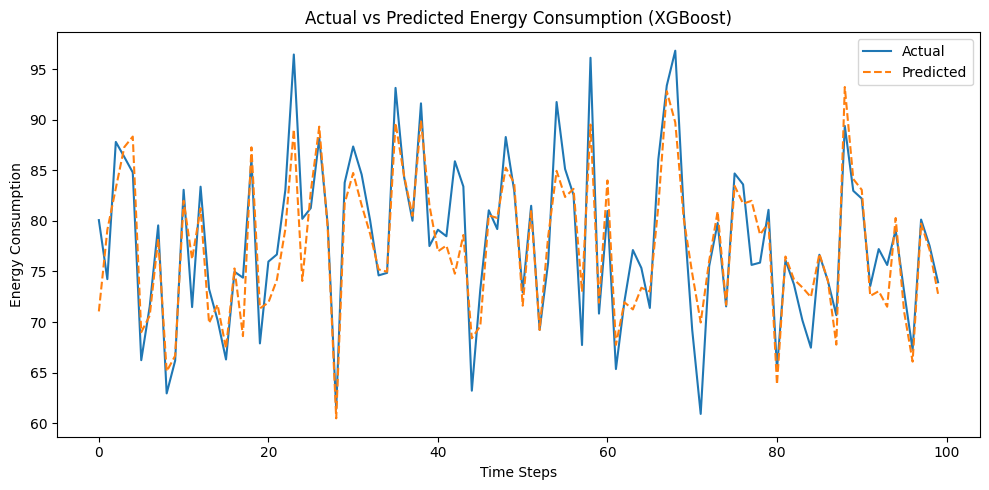

In [19]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted', linestyle='--')
plt.title("Actual vs Predicted Energy Consumption (XGBoost)")
plt.xlabel("Time Steps")
plt.ylabel("Energy Consumption")
plt.legend()
plt.tight_layout()
plt.show()


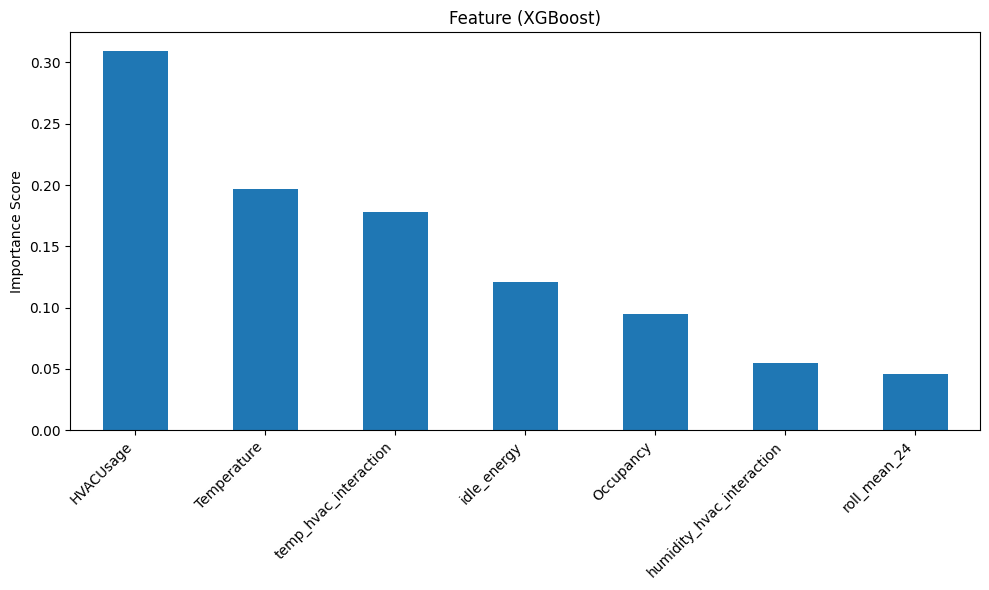

In [22]:
importance = pd.Series(
    xgb_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importance.plot(kind='bar')
plt.title("Feature (XGBoost)")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [21]:
import os

os.makedirs("artifacts/xgboost", exist_ok=True)

with open("artifacts/xgboost/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)


## Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

mae_lr  = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr   = r2_score(y_test, y_pred_lr)

print("Linear Regression R2:", r2_lr)


Linear Regression R2: 0.7375125951633109


## Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf  = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)

print("Random Forest R2:", r2_rf)


Random Forest R2: 0.6908798455088832


## LightBGM

In [25]:
# LightGBM: Train, Predict, Evaluate (Single Cell)

import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define model
lgb_model = lgb.LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train
lgb_model.fit(X_train, y_train)

# Predict
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate
mae_lgb  = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb   = r2_score(y_test, y_pred_lgb)

print("LightGBM Results")
print("-----------------")
print("MAE :", mae_lgb)
print("RMSE:", rmse_lgb)
print("R2  :", r2_lgb)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 7
[LightGBM] [Info] Start training from score 76.918236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

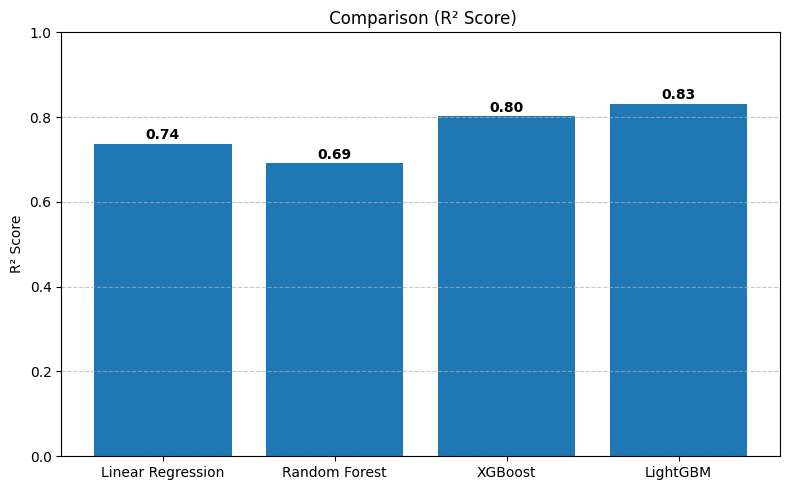

In [28]:
import matplotlib.pyplot as plt
import pandas as pd


comparison = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Random Forest',
        'XGBoost',
        'LightGBM'
    ],
    'R2 Score': [
        r2_lr,
        r2_rf,
        r2,
        r2_lgb
    ]
})


plt.figure(figsize=(8,5))
plt.bar(comparison['Model'], comparison['R2 Score'])
plt.title(' Comparison (R² Score)')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for i, v in enumerate(comparison['R2 Score']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
